In [1]:
from pennylane import numpy as np
from tensorflow import keras
from matplotlib import pyplot as plt
import tensorflow as tf
import seaborn as sns

from utils.tools import get_dataset, visualise_data

2025-03-17 10:48:49.055038: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742168929.070932  204754 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742168929.075873  204754 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742168929.088364  204754 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742168929.088377  204754 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742168929.088379  204754 computation_placer.cc:177] computation placer alr

I0000 00:00:1742168931.362906  204754 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11433 MB memory:  -> device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:02:00.0, compute capability: 6.0


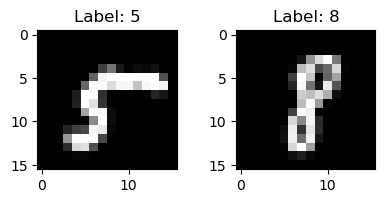

In [2]:
digits = [5,8]
n_px = 16

(x_train, y_train), (x_test, y_test) = get_dataset(digits=digits, n_px=n_px)

# show one image from each class
x_vis = [(x_train[y_train==digit])[np.random.choice(range(10))] for digit in digits] 
y_vis = range(len(digits))

visualise_data(digits, x_vis, y_vis)

### Classical model
from PennyLane demo Quanvolutional NN

In [6]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam', # stochastic-gradient-descent
        loss="sparse_categorical_crossentropy", # cross-entropy
        metrics=["accuracy"],
    )
    return model

In [7]:
c_model = MyModel()
c_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [8]:
c_history = c_model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    batch_size=4,
    epochs=30,
    verbose=2,
)

Epoch 1/30
200/200 - 2s - 10ms/step - accuracy: 0.6963 - loss: 0.8856 - val_accuracy: 0.8900 - val_loss: 0.4900
Epoch 2/30
200/200 - 1s - 3ms/step - accuracy: 0.8963 - loss: 0.4399 - val_accuracy: 0.9350 - val_loss: 0.3368
Epoch 3/30
200/200 - 1s - 3ms/step - accuracy: 0.9150 - loss: 0.3348 - val_accuracy: 0.9450 - val_loss: 0.2687
Epoch 4/30
200/200 - 1s - 3ms/step - accuracy: 0.9237 - loss: 0.2801 - val_accuracy: 0.9500 - val_loss: 0.2299
Epoch 5/30
200/200 - 1s - 3ms/step - accuracy: 0.9312 - loss: 0.2451 - val_accuracy: 0.9550 - val_loss: 0.2026
Epoch 6/30
200/200 - 1s - 3ms/step - accuracy: 0.9388 - loss: 0.2221 - val_accuracy: 0.9550 - val_loss: 0.1850
Epoch 7/30
200/200 - 1s - 3ms/step - accuracy: 0.9388 - loss: 0.2027 - val_accuracy: 0.9550 - val_loss: 0.1698
Epoch 8/30
200/200 - 1s - 3ms/step - accuracy: 0.9425 - loss: 0.1875 - val_accuracy: 0.9600 - val_loss: 0.1681
Epoch 9/30
200/200 - 1s - 3ms/step - accuracy: 0.9425 - loss: 0.1773 - val_accuracy: 0.9550 - val_loss: 0.1517


In [9]:
def ClassicalModel(n_px, digits):
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Input((n_px,n_px,1)),
        keras.layers.Flatten(),
        keras.layers.Dense(16),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam', # stochastic-gradient-descent
        loss="sparse_categorical_crossentropy", # cross-entropy
        metrics=["accuracy"],
    )
    return model

In [10]:
c_model = ClassicalModel(n_px, digits)
c_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         4,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,282 (16.73 KB)

 Trainable params: 4,282 (16.73 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
n_epochs = 30   # Number of optimization epochs

In [11]:
# c_model = ClassicalModel()

c_history = c_model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    batch_size=4,
    epochs=30,
    verbose=2,
)

Epoch 1/30
200/200 - 2s - 11ms/step - accuracy: 0.7962 - loss: 0.6491 - val_accuracy: 0.9500 - val_loss: 0.2609
Epoch 2/30
200/200 - 1s - 4ms/step - accuracy: 0.9325 - loss: 0.2426 - val_accuracy: 0.9500 - val_loss: 0.1658
Epoch 3/30
200/200 - 1s - 3ms/step - accuracy: 0.9388 - loss: 0.1778 - val_accuracy: 0.9500 - val_loss: 0.1332
Epoch 4/30
200/200 - 1s - 4ms/step - accuracy: 0.9500 - loss: 0.1492 - val_accuracy: 0.9650 - val_loss: 0.1224
Epoch 5/30
200/200 - 1s - 3ms/step - accuracy: 0.9600 - loss: 0.1260 - val_accuracy: 0.9600 - val_loss: 0.1165
Epoch 6/30
200/200 - 1s - 3ms/step - accuracy: 0.9675 - loss: 0.1120 - val_accuracy: 0.9600 - val_loss: 0.1137
Epoch 7/30
200/200 - 1s - 4ms/step - accuracy: 0.9638 - loss: 0.1002 - val_accuracy: 0.9550 - val_loss: 0.1089
Epoch 8/30
200/200 - 1s - 4ms/step - accuracy: 0.9737 - loss: 0.0924 - val_accuracy: 0.9600 - val_loss: 0.1144
Epoch 9/30
200/200 - 1s - 4ms/step - accuracy: 0.9712 - loss: 0.0868 - val_accuracy: 0.9650 - val_loss: 0.1161


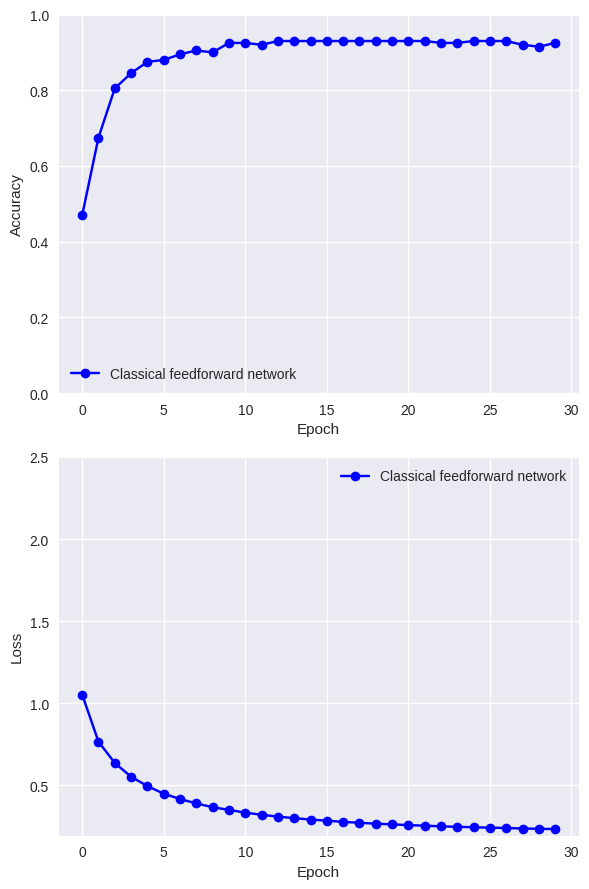

In [15]:
plt.style.use("seaborn-v0_8")
fig, ax = plt.subplots(2, 1, figsize=(6,9))

ax[0].plot(c_history.history["val_accuracy"], "-ob", label="Classical feedforward network")
ax[0].set_ylabel("Accuracy")
ax[0].set_ylim([0, 1])
ax[0].set_xlabel("Epoch")
ax[0].legend()

ax[1].plot(c_history.history["val_loss"], "-ob", label="Classical feedforward network")
ax[1].set_ylabel("Loss")
ax[1].set_ylim(top=2.5)
ax[1].set_xlabel("Epoch")
ax[1].legend()

plt.tight_layout()
plt.show()

In [12]:
def create_classical_model_CNN():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(
        tf.keras.layers.Conv2D(32, [3, 3],
                               activation='relu',
                               input_shape=(n_px, n_px, 1)))
    model.add(tf.keras.layers.Conv2D(64, [3, 3], activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_classical_model_CNN()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

/home/pranay/miniforge3/envs/qml/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 313,985 (1.20 MB)

 Trainable params: 313,985 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=1,
          verbose=1,
          validation_data=(x_test, y_test))

cnn_results = model.evaluate(x_test, y_test)

2025-03-17 10:51:46.472639: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.7 = (f32[128,64,12,12]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,32,14,14]{3,2,1,0} %bitcast.7065, f32[64,32,3,3]{3,2,1,0} %bitcast.6594, f32[64]{0} %bitcast.7125), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_3_1/conv2d_1_2/convolution" source_file="/home/pranay/miniforge3/envs/qml/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}


1/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.0000e+00 - loss: 0.4587

2025-03-17 10:51:48.306873: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.7 = (f32[32,64,12,12]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,14,14]{3,2,1,0} %bitcast.7065, f32[64,32,3,3]{3,2,1,0} %bitcast.6594, f32[64]{0} %bitcast.7125), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_3_1/conv2d_1_2/convolution" source_file="/home/pranay/miniforge3/envs/qml/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.0000e+00 - loss: -6.5416

2025-03-17 10:51:49.937878: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.7 = (f32[128,64,12,12]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,32,14,14]{3,2,1,0} %bitcast.371, f32[64,32,3,3]{3,2,1,0} %bitcast.378, f32[64]{0} %bitcast.380), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_3_1/conv2d_1_2/convolution" source_file="/home/pranay/miniforge3/envs/qml/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-03-17 10:51:50.205531: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentia

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 425ms/step - accuracy: 0.0000e+00 - loss: -7.4570 - val_accuracy: 0.0000e+00 - val_loss: -62.4373
1/7 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step - accuracy: 0.0000e+00 - loss: -61.5510

2025-03-17 10:51:50.575704: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.7 = (f32[32,64,12,12]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,14,14]{3,2,1,0} %bitcast.371, f32[64,32,3,3]{3,2,1,0} %bitcast.378, f32[64]{0} %bitcast.380), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_3_1/conv2d_1_2/convolution" source_file="/home/pranay/miniforge3/envs/qml/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.0000e+00 - loss: -62.1747 

2025-03-17 10:51:50.912159: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.7 = (f32[8,64,12,12]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,32,14,14]{3,2,1,0} %bitcast.371, f32[64,32,3,3]{3,2,1,0} %bitcast.378, f32[64]{0} %bitcast.380), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_3_1/conv2d_1_2/convolution" source_file="/home/pranay/miniforge3/envs/qml/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.0000e+00 - loss: -62.2075


<Axes: >

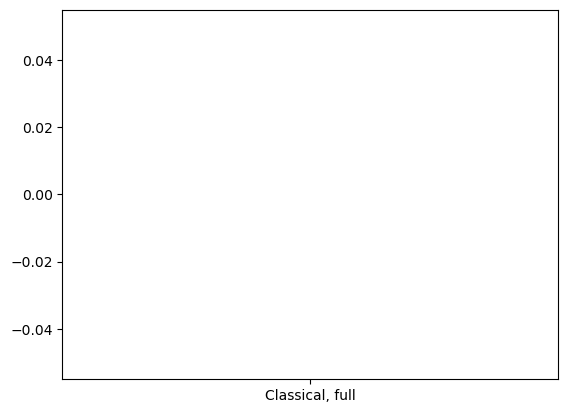

In [11]:
# qnn_accuracy = qnn_results[1]
cnn_accuracy = cnn_results[1]
# fair_nn_accuracy = fair_nn_results[1]

sns.barplot(x=["Classical, full"],
            y=[cnn_accuracy])

In [18]:
def create_classical_model(n_px, digits):
    model = keras.Sequential([
        keras.Input(shape=(n_px,n_px,1)),
        keras.layers.Flatten(),
        # select the dense layer outputs to match quantum model #parameters
        keras.layers.Dense(16, activation='relu'),
        # keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])

    return model

def create_classical_model_CNN(n_px, digits):
    model = keras.Sequential([
        keras.Input(shape=(n_px,n_px,1)),
        keras.layers.Conv2D(32, [3,3], activation='relu'),
        keras.layers.Conv2D(64, [3, 3], activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(0.25),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation='softmax')
    ])

    return model

In [19]:
classical_model = create_classical_model(n_px, digits)
classical_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)
classical_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_6 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │         4,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,282 (16.73 KB)

 Trainable params: 4,282 (16.73 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
classical_model_CNN = create_classical_model_CNN(n_px, digits)
classical_model_CNN.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)
classical_model_CNN.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315,146 (1.20 MB)

 Trainable params: 315,146 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
c_history = classical_model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    batch_size=4,
    epochs=30,
    verbose=2
)

# classical_model_results = classical_model.evaluate(x_test, y_test)

Epoch 1/30
200/200 - 2s - 11ms/step - accuracy: 0.6400 - loss: 1.0233 - val_accuracy: 0.9100 - val_loss: 0.3650
Epoch 2/30
200/200 - 1s - 4ms/step - accuracy: 0.9137 - loss: 0.2908 - val_accuracy: 0.9550 - val_loss: 0.2033
Epoch 3/30
200/200 - 1s - 4ms/step - accuracy: 0.9388 - loss: 0.1967 - val_accuracy: 0.9450 - val_loss: 0.1496
Epoch 4/30
200/200 - 1s - 4ms/step - accuracy: 0.9500 - loss: 0.1498 - val_accuracy: 0.9600 - val_loss: 0.1222
Epoch 5/30
200/200 - 1s - 4ms/step - accuracy: 0.9538 - loss: 0.1232 - val_accuracy: 0.9600 - val_loss: 0.1059
Epoch 6/30
200/200 - 1s - 4ms/step - accuracy: 0.9688 - loss: 0.0959 - val_accuracy: 0.9600 - val_loss: 0.1023
Epoch 7/30
200/200 - 1s - 3ms/step - accuracy: 0.9725 - loss: 0.0795 - val_accuracy: 0.9550 - val_loss: 0.0978
Epoch 8/30
200/200 - 1s - 3ms/step - accuracy: 0.9737 - loss: 0.0712 - val_accuracy: 0.9650 - val_loss: 0.1050
Epoch 9/30
200/200 - 1s - 4ms/step - accuracy: 0.9787 - loss: 0.0587 - val_accuracy: 0.9600 - val_loss: 0.0897


In [27]:
CNN_history = classical_model_CNN.fit(x_train,
                   y_train,
                   batch_size=100,
                   epochs=8,
                   verbose=2,
                   validation_data=(x_test, y_test))

# classical_model_CNN_results = classical_model_CNN.evaluate(x_test, y_test)

Epoch 1/8
8/8 - 0s - 14ms/step - accuracy: 0.9737 - loss: 0.0816 - val_accuracy: 0.9800 - val_loss: 0.0492
Epoch 2/8
8/8 - 0s - 11ms/step - accuracy: 0.9825 - loss: 0.0714 - val_accuracy: 0.9900 - val_loss: 0.0355
Epoch 3/8
8/8 - 0s - 10ms/step - accuracy: 0.9800 - loss: 0.0566 - val_accuracy: 0.9850 - val_loss: 0.0386
Epoch 4/8
8/8 - 0s - 10ms/step - accuracy: 0.9787 - loss: 0.0557 - val_accuracy: 0.9850 - val_loss: 0.0416
Epoch 5/8
8/8 - 0s - 10ms/step - accuracy: 0.9875 - loss: 0.0480 - val_accuracy: 0.9900 - val_loss: 0.0293
Epoch 6/8
8/8 - 0s - 10ms/step - accuracy: 0.9862 - loss: 0.0411 - val_accuracy: 0.9900 - val_loss: 0.0308
Epoch 7/8
8/8 - 0s - 10ms/step - accuracy: 0.9925 - loss: 0.0338 - val_accuracy: 0.9800 - val_loss: 0.0478
Epoch 8/8
8/8 - 0s - 10ms/step - accuracy: 0.9837 - loss: 0.0406 - val_accuracy: 0.9950 - val_loss: 0.0199


In [23]:
classical_model_CNN_results

[0.06047125905752182, 0.9800000190734863]

In [26]:
c_history.history["val_accuracy"]

[0.9100000262260437,
 0.9549999833106995,
 0.9449999928474426,
 0.9599999785423279,
 0.9599999785423279,
 0.9599999785423279,
 0.9549999833106995,
 0.9649999737739563,
 0.9599999785423279,
 0.9599999785423279,
 0.9700000286102295,
 0.9649999737739563,
 0.9649999737739563,
 0.9649999737739563,
 0.9700000286102295,
 0.9649999737739563,
 0.9649999737739563,
 0.9649999737739563,
 0.9649999737739563,
 0.9599999785423279,
 0.9649999737739563,
 0.9599999785423279,
 0.9599999785423279,
 0.9649999737739563,
 0.9649999737739563,
 0.9649999737739563,
 0.9599999785423279,
 0.9599999785423279,
 0.9599999785423279,
 0.9599999785423279]

In [28]:
CNN_history.history['val_accuracy']

[0.9800000190734863,
 0.9900000095367432,
 0.9850000143051147,
 0.9850000143051147,
 0.9900000095367432,
 0.9900000095367432,
 0.9800000190734863,
 0.9950000047683716]